In [44]:
# dataset
from keras.datasets import cifar10

import joblib
import numpy as np
import cv2 as cv
from skimage.feature import hog

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
from tabulate import tabulate

# utilities
# from sklearn.preprocessing import minmax_scale, scale
# from sklearn.model_selection import train_test_split, GridSearchCV

# models
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import calinski_harabasz_score
# from sklearn.metrics import accuracy_score

# 1. Load Data

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank"> CIFAR-10 </a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [2]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [3]:
X_train = X_train.astype('uint8')
X_test = X_test.astype('uint8')

In [4]:
print(f'Total train data: {X_train.shape[0]}')
print(f'Total test data: {X_test.shape[0]}')
print(f'Image dimensions: {X_train.shape[1], X_train.shape[2], X_train.shape[3]}')

Total train data: 50000
Total test data: 10000
Image dimensions: (32, 32, 3)


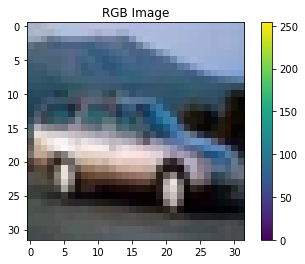

In [5]:
plt.imshow(X_train[4])

plt.title('RGB Image')
plt.colorbar()

# 2. Preprocessing

The following transformations are used:
* **grayscale**: convert image from RGB to grayscale.
* <span style="color:red"><b>(deprecated)</b></span> **scale**: convert image pixels from [0, 255] range to [0, 1] range.


* <span style="color:red"><b> minmax scaling </b></span>
* <span style="color:red"><b> standardize </b></span> 

## 2.1 Grayscale

In [6]:
def to_grayscale(data):
    """ Converts RGB images to grayscale.
    
    Args:
        data:
            images in RGB format, as numpy array.
    
    Returns:
       grayscale images, as numpy array.
    """
    grayscale = np.zeros((data.shape[0], data.shape[1], data.shape[2])).astype('uint8')
    
    for idx in range(data.shape[0]):
        grayscale[idx] = cv.cvtColor(data[idx], cv.COLOR_RGB2GRAY)
    
    return grayscale

In [7]:
X_train_grayscale = to_grayscale(X_train)
X_test_grayscale = to_grayscale(X_test)

In [8]:
print(f'Image dimensions in grayscale: {X_train_grayscale.shape[1], X_train_grayscale.shape[2]}')

Image dimensions in grayscale: (32, 32)


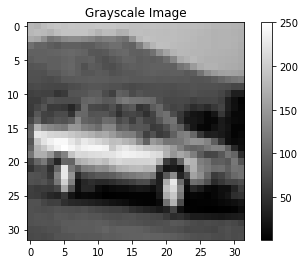

In [9]:
plt.imshow(X_train_grayscale[4], cmap='gray')

plt.title('Grayscale Image')
plt.colorbar()

## 2.2 Scaling

In [10]:
def scale(data):
    """ Scale image pixels from [0, 255] range to [0, 1] range.

    Args:
        data:
            images, as numpy array.

    Returns:
        scaled images, as numpy array.
    """
    data = data / 255.0

    return data

In [11]:
X_train_scaled = scale(X_train_grayscale)
X_test_scaled = scale(X_test_grayscale)

In [12]:
print(f'Image pixels after scaling:\n{X_train_scaled[4]}')

Image pixels after scaling:
[[0.70196078 0.69411765 0.7254902  ... 0.69803922 0.69019608 0.68627451]
 [0.70196078 0.71764706 0.70980392 ... 0.69019608 0.68235294 0.6745098 ]
 [0.65490196 0.63529412 0.55686275 ... 0.69411765 0.68627451 0.6745098 ]
 ...
 [0.31764706 0.32156863 0.3254902  ... 0.29019608 0.27843137 0.25098039]
 [0.29019608 0.29411765 0.30196078 ... 0.30980392 0.29019608 0.29019608]
 [0.28627451 0.29019608 0.28627451 ... 0.30588235 0.29019608 0.29803922]]


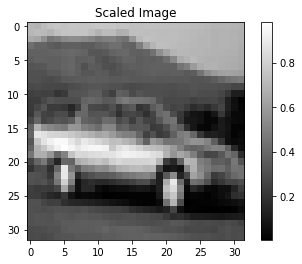

In [13]:
plt.imshow(X_train_scaled[4], cmap='gray')

plt.title('Scaled Image')
plt.colorbar()

# 3. Features

The following features are extracted from images:
* <a href="https://docs.opencv.org/4.5.2/d1/db7/tutorial_py_histogram_begins.html" target="_blank"> Gray Color Histogram (GCH) </a>
* <a href="https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html" target="_blank"> Histogram of Oriented Gradients (HOG) </a>
* <a href="https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html" target="_blank"> Scale-Invariant Feature Transform (SIFT) </a>

## 3.1 Gray Color Histogram

In [14]:
def color_histogram(data):
    """ Extracts gray color histograms.
    
    Args:
        data:
            images in grayscale format, as numpy array.
    
    Returns:
        gray color histograms, as list of numpy arrays.
    """
    color_hists = []
    
    for idx in range(data.shape[0]):
        color_hist = cv.calcHist([data[idx]], [0], None, [256], [0,256])
        color_hists.append(color_hist.ravel())
    
    return color_hists

In [15]:
color_hist_train = color_histogram(X_train_grayscale)
color_hist_test = color_histogram(X_test_grayscale)

In [16]:
print(f'Image gray color histogram, first 10 values: {color_hist_train[4][:10]}\n') 
print(f'Size of image gray color histogram: {color_hist_train[4].shape}')

Image gray color histogram, first 10 values: [ 0.  4.  4.  6. 10.  6.  3.  4.  6.  7.]

Size of image gray color histogram: (256,)


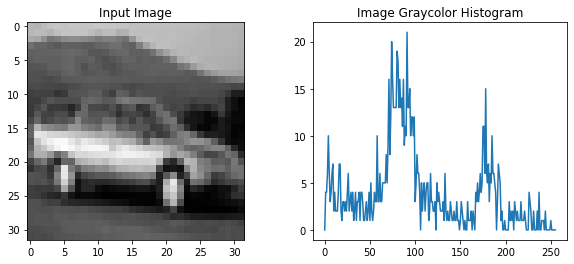

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.imshow(X_train_grayscale[4], cmap='gray')
ax1.set_title('Input Image')

ax2.plot(color_hist_train[4]); 
ax2.set_title('Image Graycolor Histogram')

plt.show()

## 3.2 Histogram of Oriented Gradients (HOG)

In [18]:
def hog_features(data):
    """ Extracts histogram of oriented gradients.
    
    Args:
        data:
            images in grayscale format, as numpy array.
    
    Returns:
        HOG descriptors, as list of numpy arrays.
        HOG images, as list of numpy arrays.
    """
    hog_descriptors = []
    hog_images = []
    
    for idx in range(data.shape[0]):
        fd, hog_image = hog(data[idx], 
                            orientations=9, 
                            pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), 
                            block_norm='L2-Hys',
                            transform_sqrt=True,
                            feature_vector=True,
                            visualize=True)  
        hog_descriptors.append(fd)
        hog_images.append(hog_image)
    
    return hog_descriptors, hog_images

In [19]:
hog_train, hog_train_img = hog_features(X_train_grayscale)
hog_test, hog_test_img = hog_features(X_test_grayscale)

In [20]:
print(f'Image HOG, first 6 values: {hog_train[4][:6]}\n')
print(f'Size of image HOG: {hog_train[4].shape}')

Image HOG, first 6 values: [0.05613025 0.01108392 0.0912732  0.1247402  0.29826597 0.27952999]

Size of image HOG: (324,)


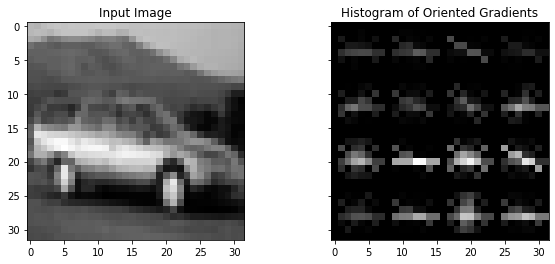

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

ax1.imshow(X_train_grayscale[4], cmap='gray')
ax1.set_title('Input Image')

ax2.imshow(hog_train_img[4], cmap='gray')
ax2.set_title('Histogram of Oriented Gradients')

plt.show()

## 3.3 Scale-Invariant Feature Transform (SIFT)

In [22]:
def sift_features(data):
    """ Extracts image SIFT keypoints and descriptors.
    
    Args:
        data:
            images in grayscale format, as numpy array.
    
    Returns:
        SIFT keypoints, as list of lists.
        SIFT descriptors, as list of numpy array. 
    """
    sift = cv.xfeatures2d.SIFT_create(contrastThreshold=0.02, sigma=0.9)
    
    keypoints = []
    descriptors = []
    
    for idx in range(data.shape[0]):
        kp, des = sift.detectAndCompute(data[idx], None)
        keypoints.append(kp)
        descriptors.append(des)
    
    return keypoints, descriptors

In [23]:
kp_sift_train, des_sift_train = sift_features(X_train_grayscale) 
kp_sift_test, des_sift_test = sift_features(X_test_grayscale)

In [24]:
print(f'Image SIFT keypoints, first 3 values: {kp_sift_train[4][:3]}\n')
print(f'Size SIFT keypoints (image 4): {len(kp_sift_train[4])}')
print(f'Size SIFT keypoints (image 8): {len(kp_sift_train[8])}')

Image SIFT keypoints, first 3 values: [<KeyPoint 0x7f21e495fcc0>, <KeyPoint 0x7f21e495fcf0>, <KeyPoint 0x7f21e495fd20>]

Size SIFT keypoints (image 4): 37
Size SIFT keypoints (image 8): 30


In [25]:
print(f'Image SIFT descriptors:\n{des_sift_train[4]}\n')

print(f'Size SIFT descriptors (image 4): {des_sift_train[4].shape}')
print(f'Size SIFT descriptors (image 8): {des_sift_train[8].shape}')

Image SIFT descriptors:
[[ 27.   1.   0. ...   0.   0.   0.]
 [  0.   3.   1. ...  21.   0.   0.]
 [ 11.   7.   2. ...   9.   0.   3.]
 ...
 [ 37.   0.   0. ...   0.   6.  26.]
 [ 44.  45.  24. ...   1. 101.  33.]
 [  9.  76.  43. ...   0.   0.   0.]]

Size SIFT descriptors (image 4): (37, 128)
Size SIFT descriptors (image 8): (30, 128)


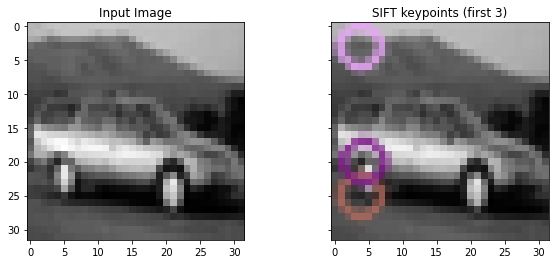

In [26]:
img = cv.drawKeypoints(X_train_grayscale[4], kp_sift_train[4][:3], None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

ax1.imshow(X_train_grayscale[4], cmap='gray')
ax1.set_title('Input Image')

ax2.imshow(img, cmap='gray')
ax2.set_title('SIFT keypoints (first 3)')

plt.show()

# 4. Bag of Visual Words (BoVW) model

We'll only insert SIFT features into the BoVW model, since GCH and HOG features are already in histogram forms.

To evaluate our BoVW, we'll use the **Elbow method** along with the **Calinski-Harabasz Index** metric.

## 4.1 Visual Vocabulary

In [27]:
def get_visual_words(descriptors, model):
    """ Finds the vocabulary of visual words.

    To find the vocabulary of visual words, k-means is used. The centroids found by k-means
    form the vocabulary.

    Args:
        descriptors:
            descriptors, as list of numpy arrays.
        model:
            clustering model, as scikit-learn object.

    Returns:
        fitted k-means, holding the vocabulary of visual words .
    """
    
    visual_words = model.fit(descriptors)

    return visual_words

In [28]:
des_sift_raw_train = []
for des in des_sift_train:
    if des is not None:
        des_sift_raw_train.extend(des)

### 4.1.1 KMeans

In [29]:
kmeans_calinski = []

for n_clusters in range(100, 1100, 100):
    print(f'Number of clusters: {n_clusters}')
    
    clustering = KMeans(n_clusters=n_clusters, n_init=10, max_iter=300)
    model = get_visual_words(descriptors=des_sift_raw_train, model=clustering)
    
    kmeans_calinski.append(calinski_harabasz_score(des_sift_raw_train, model.labels_))

Number of clusters: 100
Number of clusters: 200
Number of clusters: 300
Number of clusters: 400
Number of clusters: 500
Number of clusters: 600
Number of clusters: 700
Number of clusters: 800
Number of clusters: 900
Number of clusters: 1000


### 4.1.2 MiniBatchKMeans

In [30]:
batch_kmeans_calinski = []

for n_clusters in range(100, 1100, 100):
    print(f'Number of clusters: {n_clusters}')
    
    clustering = MiniBatchKMeans(n_clusters=n_clusters, batch_size=64, n_init=10, max_iter=300)
    model = get_visual_words(descriptors=des_sift_raw_train, model=clustering)
    
    batch_kmeans_calinski.append(calinski_harabasz_score(des_sift_raw_train, model.labels_))

Number of clusters: 100
Number of clusters: 200
Number of clusters: 300
Number of clusters: 400
Number of clusters: 500
Number of clusters: 600
Number of clusters: 700
Number of clusters: 800
Number of clusters: 900
Number of clusters: 1000


### 4.1.3 Compare BoVW models

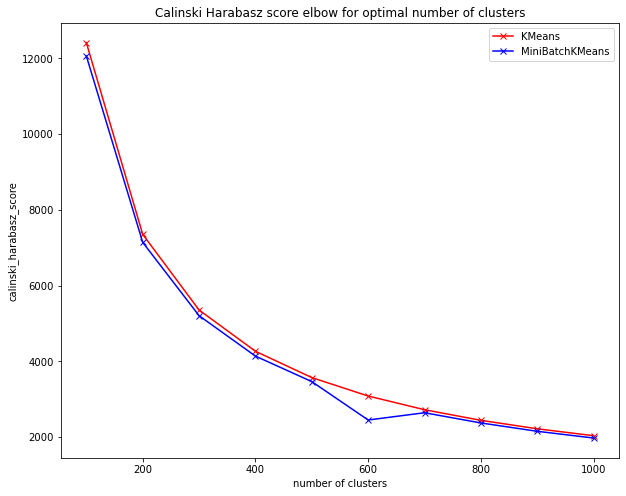

number of clusters: 100 | KMeans: 12417.300870282248 | MiniBatchKMeans: 12065.841676107673
number of clusters: 200 | KMeans: 7354.088944825345 | MiniBatchKMeans: 7142.9117955958145
number of clusters: 300 | KMeans: 5354.918102584723 | MiniBatchKMeans: 5205.224831165665
number of clusters: 400 | KMeans: 4265.446639745584 | MiniBatchKMeans: 4137.386220326259
number of clusters: 500 | KMeans: 3569.809003933928 | MiniBatchKMeans: 3463.565682543316
number of clusters: 600 | KMeans: 3082.9507691611907 | MiniBatchKMeans: 2449.1105786695334
number of clusters: 700 | KMeans: 2720.8272462223786 | MiniBatchKMeans: 2641.1788971138176
number of clusters: 800 | KMeans: 2440.8188276125557 | MiniBatchKMeans: 2371.2969690188534
number of clusters: 900 | KMeans: 2217.247229252161 | MiniBatchKMeans: 2150.7923245326583
number of clusters: 1000 | KMeans: 2034.289037327385 | MiniBatchKMeans: 1973.0435437296912


In [43]:
plt.figure(figsize=(10,8))

plt.plot(range(100, 1100, 100), kmeans_calinski, 'rx-', label='KMeans')
plt.plot(range(100, 1100, 100), batch_kmeans_calinski, 'bx-', label='MiniBatchKMeans')

plt.xlabel('number of clusters')
plt.ylabel('calinski_harabasz_score')
plt.title('Calinski Harabasz score elbow for optimal number of clusters')
plt.legend()

plt.show()

for count, value in enumerate(range(100, 1100, 100)):
    print(f'number of clusters: {value} | KMeans: {kmeans_calinski[count]} | MiniBatchKMeans: {batch_kmeans_calinski[count]}')

### 4.1.4 Best BoVW model

In [45]:
# retrain best model
bovw = get_visual_words(descriptors=des_sift_raw_train, model=KMeans(n_clusters=600, n_init=10, max_iter=300))

# save model
joblib.dump(bovw, 'bovw.joblib')

['bovw.joblib']

## 4.2 Vector Representations

In [ ]:
def get_vector_representation(model, descriptors):
    """ Computes the vector representations of images.

    The representations are based on the images descriptors and a predefined BoVW model. Specifically,
    they're a histogram of the frequencies of visual words from the vocabulary of the BoVW.

    Args:
        model:
            precomputed BoVW model, as scikit-learn obj.
        descriptors:
            descriptors, as list of numpy arrays.

    Returns:
        vector representations of images, as list of numpy array.
    """
    histograms = []
    for desc in descriptors:
        hist = np.zeros(visual_words.cluster_centers_.shape[0])
        if desc is not None:
            for d in desc:
                # find the cluster each descriptor is close to
                cluster_idx = visual_words.predict([d.astype(float)])
                hist[cluster_idx] += 1
            histograms.append(hist)
    
    return histograms

In [ ]:
des_sift_train = get_vector_representation(visual_words, des_sift_train)
des_sift_test = get_vector_representation(visual_words, des_sift_test)

# 5. Early Fusion

### 5.1 Early Fusion: HOG + GCH

In [ ]:
X_train_hog_gch = []
for idx in range(X_train_grayscale.shape[0]):
    fused = np.concatenate((des_hog_train[idx], color_hist_train[idx]), axis=None)
    X_train_hog_gch.append(fused)

X_test_hog_gch = []
for idx in range(X_test_grayscale.shape[0]):
    fused = np.concatenate((des_hog_test[idx], color_hist_test[idx]), axis=None)
    X_test_hog_gch.append(fused)

In [ ]:
print(f'Number of features: {X_train_hog_gch[0].shape[0]}')

### 5.2 Early Fusion: HOG + SIFT

In [ ]:
X_train_hog_sift = []
for idx in range(X_train_grayscale.shape[0]):
    fused = np.concatenate((des_hog_train[idx], des_sift_train[idx]), axis=None)
    X_train_hog_sift.append(fused)

X_test_hog_sift = []
for idx in range(X_test_grayscale.shape[0]):
    fused = np.concatenate((des_hog_test[idx], des_sift_test[idx]), axis=None)
    X_test_hog_sift.append(fused)

In [ ]:
print(f'Number of features: {X_train_hog_sift[0].shape[0]}')

### 5.3 Early Fusion: HOG + GCH + SIFT

In [ ]:
X_train_hog_gch_sift = []
for idx in range(X_train_grayscale.shape[0]):
    fused = np.concatenate((des_hog_train[idx], color_hist_train[idx]), axis=None)
    fused = np.concatenate((fused, des_sift_train[idx]), axis=None)
    X_train_hog_gch_sift.append(fused)

X_test_hog_gch_sift = []
for idx in range(X_test_grayscale.shape[0]):
    fused = np.concatenate((des_hog_test[idx], color_hist_test[idx]), axis=None)
    fused = np.concatenate((fused, des_sift_test[idx]), axis=None)
    X_test_hog_gch_sift.append(fused)

In [ ]:
print(f'Number of features: {X_train_hog_gch_sift[0].shape[0]}')

# 6. Scaling

### 6.1 Minmax Scaling

In [ ]:
X_train_scaled = minmax_scale(np.array(X_train_hog_sift))
X_test_scaled = minmax_scale(np.array(X_test_hog_sift))

### 6.2 Standardize

In [ ]:
X_train_stand = scale(np.array(X_train_hog_sift))
X_test_stand = scale(np.array(X_test_hog_sift))

# 7. Classification

### 7.1 Logistic Regression

In [ ]:
# hyperparameter space
space = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [None],
    'max_iter': [5000] 
}

clf = LogisticRegression()

In [ ]:
# hyperparameter tunning & cross validation
search = GridSearchCV(clf, space, scoring="accuracy", cv=10)
results = search.fit(X_train_hog_sift, Y_train.ravel())

print(results.best_score_)
print(results.best_params_)

In [ ]:
clf = LogisticRegression(C=10, class_weight=None, max_iter=5000)

clf.fit(X_train_hog_sift, Y_train.ravel())

Y_train_pred = clf.predict(X_train_hog_sift)
Y_test_pred = clf.predict(X_test_hog_sift)

print(f'Train accuracy: {accuracy_score(Y_train.ravel(), Y_train_pred)}')
print(f'Test accuracy: {accuracy_score(Y_test.ravel(), Y_test_pred)}')

### 7.2 kNN

In [ ]:
# hyperparameter space
space = {
    'n_neighbors': list(range(1, 20, 3)),
    'weights': ['uniform', 'distance']
}

clf = KNeighborsClassifier()

In [ ]:
# hyperparameter tunning & cross validation
search = GridSearchCV(clf, space, scoring="accuracy", cv=10)
results = search.fit(X_train_hog_sift, Y_train.ravel())

print(results.best_score_)
print(results.best_params_)

In [ ]:
clf = KNeighborsClassifier(n_neighbors=19, weights='distance')

clf.fit(X_train_hog_sift, Y_train.ravel())

Y_train_pred = clf.predict(X_train_hog_sift)
Y_test_pred = clf.predict(X_test_hog_sift)

print(f'Train accuracy: {accuracy_score(Y_train.ravel(), Y_train_pred)}')
print(f'Test accuracy: {accuracy_score(Y_test.ravel(), Y_test_pred)}')

### 7.3 Random Forest

In [ ]:
# hyperparameter space
max_depth = (np.linspace(10, 50, num = 5).astype(int)).tolist()
max_depth.append(None)
space = {
    'n_estimators': list(range(10, 101, 10)),
    'max_depth': max_depth ,
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
}

clf = RandomForestClassifier()

In [ ]:
# hyperparameter tunning & cross validation
search = GridSearchCV(clf, space, scoring="accuracy", cv=10)
results = search.fit(X_train_hog_sift, Y_train.ravel())

print(results.best_score_)
print(results.best_params_)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)

clf.fit(X_train_hog_sift, Y_train.ravel())

Y_train_pred = clf.predict(X_train_hog_sift)
Y_test_pred = clf.predict(X_test_hog_sift)

print(f'Train accuracy: {accuracy_score(Y_train.ravel(), Y_train_pred)}')
print(f'Test accuracy: {accuracy_score(Y_test.ravel(), Y_test_pred)}')